In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
tf.__version__

'2.13.0'

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 10

# Dataset reading


## Giá trị của dữ liệu

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

## Nhãn của dữ liệu

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

## Chia tập dữ liệu

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
81/89 [==========================>...] - ETA: 0s - loss: 2.0808 - accuracy: 0.2579 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
89/89 [==============================] - 0s 2ms/step - loss: 2.0602 - accuracy: 0.2631 - val_loss: 1.6996 - val_accuracy: 0.3330
Epoch 2/1000
76/89 [========================>.....] - ETA: 0s - loss: 1.6197 - accuracy: 0.3534
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
89/89 [==============================] - 0s 1ms/step - loss: 1.5948 - accuracy: 0.3593 - val_loss: 1.2134 - val_accuracy: 0.4690
Epoch 3/1000
84/89 [===========================>..] - ETA: 0s - loss: 1.2919 - accuracy: 0.4486
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
89/89 [==============================] - 0s 1ms/step - loss: 1.2852 - accuracy: 0.4518 - val_loss: 0.9117 - val_accuracy: 0.6905
Epoch 4/1000
82/89 [==========================>...] - ETA: 0s - loss: 1.1107 - accuracy: 0.52

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

30/30 [==============================] - 0s 448us/step - loss: 0.0636 - accuracy: 0.9976


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 37ms/step
[9.9669778e-01 2.6838620e-11 3.6976246e-05 3.0883097e-08 8.2271261e-04
 9.6271797e-05 4.0411419e-04 1.9411647e-03 5.4614577e-07 5.1687039e-07]
0


# Confusion matrix

119/119 [==============================] - 0s 350us/step


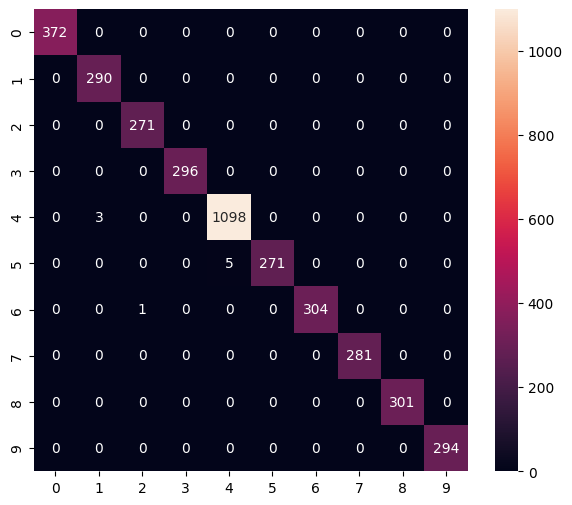

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       372
           1       0.99      1.00      0.99       290
           2       1.00      1.00      1.00       271
           3       1.00      1.00      1.00       296
           4       1.00      1.00      1.00      1101
           5       1.00      0.98      0.99       276
           6       1.00      1.00      1.00       305
           7       1.00      1.00      1.00       281
           8       1.00      1.00      1.00       301
           9       1.00      1.00      1.00       294

    accuracy                           1.00      3787
   macro avg       1.00      1.00      1.00      3787
weighted avg       1.00      1.00      1.00      3787



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
# model.save(model_save_path, include_optimizer=False)
model.save(model_save_path)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [
#                 tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
#                 tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
#             ]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpkf2bgrd0\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpkf2bgrd0\assets


6808

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.9669766e-01 2.6838616e-11 3.6976202e-05 3.0883090e-08 8.2271354e-04
 9.6272051e-05 4.0411411e-04 1.9411654e-03 5.4614560e-07 5.1687078e-07]
0
